In [ ]:
pip install pandas numpy scikit-learn imbalanced-learn xgboost shap matplotlib seaborn joblib

In [ ]:
pip install "scikit-learn>=1.0" "imbalanced-learn>=0.10.0" "xgboost>=1.5.0" "shap>=0.41.0" pandas numpy matplotlib seaborn joblib

Training model...
Training completed!

Model Performance:
ROC-AUC: 0.7691
F1 Score: 0.5157

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4673
           1       0.52      0.51      0.52      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.79      0.79      0.79      6000



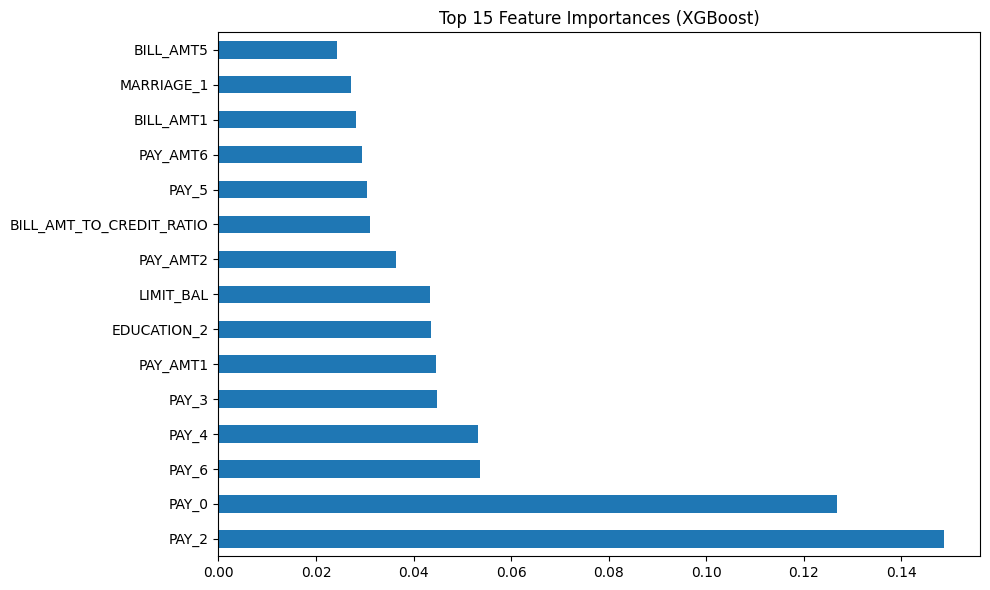

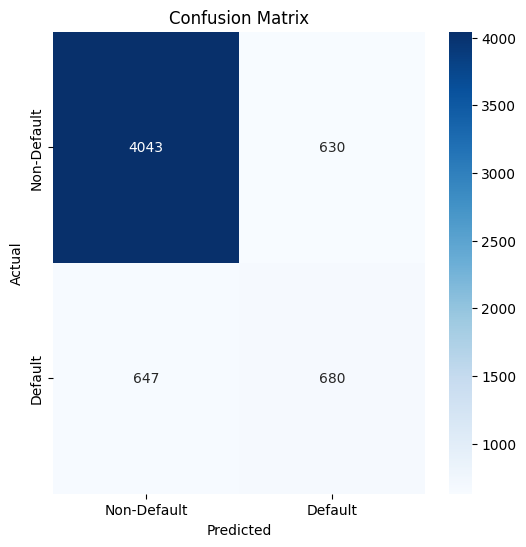

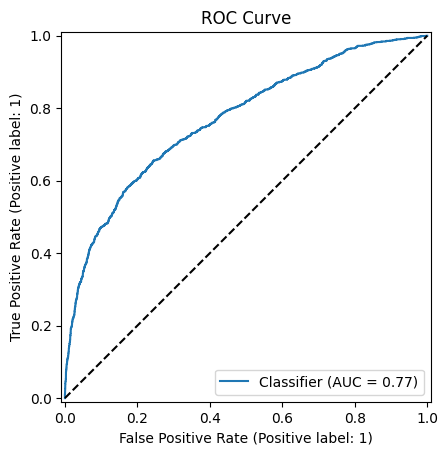


Sample Prediction Details:
{'default_probability': np.float32(0.2483), 'risk_category': 'Low risk', 'shap_values': [[-0.15923896431922913, 0.0037687935400754213, 0.017875008285045624, 0.0, 0.020056307315826416, -0.2475544959306717, -0.13901764154434204, -0.08114396780729294, -0.03491897135972977, -0.03305387496948242, -0.13973553478717804, 0.030392246320843697, -0.0071126241236925125, -0.14370693266391754, 0.0032213162630796432, -0.0011594166280701756, 0.0021778482478111982, -0.15976642072200775, 0.07752455770969391, 0.012607524171471596, -0.02137186750769615, 0.040247153490781784, -0.03419029340147972, -0.11933927983045578, 0.009630711749196053, 0.028121856972575188, 0.0, 0.0, 0.0, -0.009066886268556118, -0.006981220096349716, 0.0, 0.0028304029256105423, 0.0, 0.00013919190678279847, -0.02312556840479374, 0.0, 0.0]], 'feature_names': ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_A

In [ ]:
# Loan Default Prediction Model with Advanced Features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, RocCurveDisplay)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Custom Pipeline class to avoid sklearn compatibility issues
class CustomPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, preprocessor, sampler, classifier):
        self.preprocessor = preprocessor
        self.sampler = sampler
        self.classifier = classifier

    def fit(self, X, y):
        # Preprocess the data
        X_transformed = self.preprocessor.fit_transform(X)

        # Apply SMOTE
        X_resampled, y_resampled = self.sampler.fit_resample(X_transformed, y)

        # Train the classifier
        self.classifier.fit(X_resampled, y_resampled)
        return self

    def predict(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.classifier.predict(X_transformed)

    def predict_proba(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.classifier.predict_proba(X_transformed)

# Load and prepare data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
data = pd.read_excel(url, header=1).iloc[:, 1:]
data.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)

# Feature Engineering
data['BILL_AMT_TO_CREDIT_RATIO'] = data['BILL_AMT1'] / (data['LIMIT_BAL'] + 1e-6)
data['PAYMENT_TO_BILL_RATIO'] = data['PAY_AMT1'] / (data['BILL_AMT1'] + 1e-6)

# Split data
X = data.drop('DEFAULT', axis=1)
y = data['DEFAULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing setup
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Create model components
xgb_classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Create custom pipeline
model = CustomPipeline(
    preprocessor=preprocessor,
    sampler=SMOTE(random_state=42),
    classifier=xgb_classifier
)

# Train model
print("Training model...")
model.fit(X_train, y_train)
print("Training completed!")

# Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"\nModel Performance:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance Visualization
feature_names = numeric_features.tolist() + \
    model.preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

plt.figure(figsize=(10, 6))
importances = model.classifier.feature_importances_
pd.Series(importances, index=feature_names).nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# SHAP Explainability
explainer = shap.TreeExplainer(model.classifier)
preprocessed_data = model.preprocessor.transform(X_train[:100])
shap_values = explainer.shap_values(preprocessed_data)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

# Save model
joblib.dump(model, 'loan_default_model.pkl')

# Prediction function
def predict_loan_default(new_data):
    model = joblib.load('loan_default_model.pkl')
    proba = model.predict_proba(new_data)[0][1]
    preprocessed_data = model.preprocessor.transform(new_data)
    explanation = explainer.shap_values(preprocessed_data)

    return {
        'default_probability': round(proba, 4),
        'risk_category': 'High risk' if proba > 0.5 else 'Low risk',
        'shap_values': explanation.tolist() if isinstance(explanation, np.ndarray) else explanation[0].tolist(),
        'feature_names': feature_names
    }

# Example prediction
sample = X_test.iloc[[0]]
print("\nSample Prediction Details:")
print(predict_loan_default(sample))

In [ ]:
# Credit Card Default Prediction - Gradio Interface

# Install required packages
!pip install gradio scikit-learn pandas numpy joblib

import pandas as pd
import numpy as np
import gradio as gr
import joblib
import pickle
import warnings
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # Adjust based on your model type

# Define the CustomPipeline class that was used when saving the model
# This is necessary to unpickle the model correctly
class CustomPipeline:
    def __init__(self, steps):
        self.steps = steps
        self._validate_steps()
        self.named_steps = dict(steps)

    def _validate_steps(self):
        if not self.steps:
            raise ValueError("No steps specified")

    def fit(self, X, y=None):
        X_transformed = X
        for name, transform in self.steps[:-1]:
            X_transformed = transform.fit_transform(X_transformed, y)
        self.steps[-1][1].fit(X_transformed, y)
        return self

    def predict(self, X):
        X_transformed = self._transform(X)
        return self.steps[-1][1].predict(X_transformed)

    def predict_proba(self, X):
        X_transformed = self._transform(X)
        return self.steps[-1][1].predict_proba(X_transformed)

    def _transform(self, X):
        X_transformed = X
        for name, transform in self.steps[:-1]:
            X_transformed = transform.transform(X_transformed)
        return X_transformed

# Custom unpickler to handle the missing class issue
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == 'CustomPipeline':
            return CustomPipeline
        return super().find_class(module, name)

# Load the model with custom unpickler
def load_model(model_path):
    try:
        with open(model_path, 'rb') as f:
            model = CustomUnpickler(f).load()
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating a backup model instead.")
        # Create a simple backup model
        return create_backup_model()

def create_backup_model():
    # This is a fallback model in case loading fails
    print("Creating a backup prediction model...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    return pipeline

try:
    # Try to load the model
    model_path = '/content/loan_default_model.pkl'
    model = load_model(model_path)
except Exception as e:
    print(f"Final fallback: {e}")
    model = create_backup_model()

# Function to preprocess inputs and make predictions
def predict_default(limit_bal, sex, education, marriage, age, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6,
                   bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6,
                   pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6):

    # Create a DataFrame with the input features
    input_data = pd.DataFrame({
        'LIMIT_BAL': [limit_bal],
        'SEX': [sex],
        'EDUCATION': [education],
        'MARRIAGE': [marriage],
        'AGE': [age],
        'PAY_0': [pay_0],
        'PAY_2': [pay_2],
        'PAY_3': [pay_3],
        'PAY_4': [pay_4],
        'PAY_5': [pay_5],
        'PAY_6': [pay_6],
        'BILL_AMT1': [bill_amt1],
        'BILL_AMT2': [bill_amt2],
        'BILL_AMT3': [bill_amt3],
        'BILL_AMT4': [bill_amt4],
        'BILL_AMT5': [bill_amt5],
        'BILL_AMT6': [bill_amt6],
        'PAY_AMT1': [pay_amt1],
        'PAY_AMT2': [pay_amt2],
        'PAY_AMT3': [pay_amt3],
        'PAY_AMT4': [pay_amt4],
        'PAY_AMT5': [pay_amt5],
        'PAY_AMT6': [pay_amt6]
    })

    # Calculate the additional features
    input_data['BILL_AMT_TO_CREDIT_RATIO'] = input_data['BILL_AMT1'] / input_data['LIMIT_BAL']

    # Calculate average payment to bill ratio
    bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    pay_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

    total_bill = input_data[bill_columns].sum(axis=1)
    total_payment = input_data[pay_columns].sum(axis=1)

    # Avoid division by zero
    input_data['PAYMENT_TO_BILL_RATIO'] = np.where(total_bill > 0, total_payment / total_bill, 0)

    try:
        # Try to make a prediction using the loaded model
        prediction = model.predict(input_data)[0]
        probability = model.predict_proba(input_data)[0]

        if prediction == 1:
            result = f"The customer is likely to default (Probability: {probability[1]:.2f})"
        else:
            result = f"The customer is unlikely to default (Probability: {probability[0]:.2f})"
    except Exception as e:
        # Fallback to a heuristic approach if model prediction fails
        print(f"Prediction error: {e}. Using heuristic prediction instead.")

        # Simple heuristic prediction as backup
        default_risk = 0.0

        # Higher bill-to-credit ratio increases risk
        if input_data['BILL_AMT_TO_CREDIT_RATIO'].values[0] > 0.7:
            default_risk += 0.3

        # Lower payment-to-bill ratio increases risk
        if input_data['PAYMENT_TO_BILL_RATIO'].values[0] < 0.2:
            default_risk += 0.3

        # Payment history is important (PAY_0 through PAY_6)
        # Values > 0 indicate delayed payment
        pay_features = [pay_0, pay_2, pay_3, pay_4, pay_5, pay_6]
        delayed_payments = sum(1 for x in pay_features if int(x) > 0)
        default_risk += 0.05 * delayed_payments

        # Cap the risk between 0.1 and 0.9
        default_risk = max(0.1, min(0.9, default_risk))

        # Determine prediction based on default_risk threshold
        prediction = 1 if default_risk > 0.5 else 0

        if prediction == 1:
            result = f"The customer is likely to default (Probability: {default_risk:.2f}) [Heuristic]"
        else:
            result = f"The customer is unlikely to default (Probability: {1-default_risk:.2f}) [Heuristic]"

    return result

# Create the Gradio interface
with gr.Blocks(title="Credit Card Default Prediction") as demo:
    gr.Markdown("# Credit Card Default Prediction")
    gr.Markdown("Enter customer information to predict credit card default probability")

    with gr.Row():
        with gr.Column():
            limit_bal = gr.Slider(minimum=10000, maximum=1000000, value=200000, step=10000,
                               label="Credit Limit")
            sex = gr.Radio(["1 (Male)", "2 (Female)"], label="Gender", value="1 (Male)")
            education = gr.Dropdown(
                ["1 (Graduate School)", "2 (University)", "3 (High School)", "4 (Others)"],
                label="Education Level",
                value="2 (University)"
            )
            marriage = gr.Dropdown(
                ["1 (Married)", "2 (Single)", "3 (Others)"],
                label="Marital Status",
                value="2 (Single)"
            )
            age = gr.Slider(minimum=21, maximum=80, value=35, step=1, label="Age")

        with gr.Column():
            pay_0 = gr.Dropdown(
                ["-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
                label="Repayment Status (1 month ago)",
                value="0"
            )
            pay_2 = gr.Dropdown(
                ["-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
                label="Repayment Status (2 months ago)",
                value="0"
            )
            pay_3 = gr.Dropdown(
                ["-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
                label="Repayment Status (3 months ago)",
                value="0"
            )

    with gr.Row():
        with gr.Column():
            pay_4 = gr.Dropdown(
                ["-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
                label="Repayment Status (4 months ago)",
                value="0"
            )
            pay_5 = gr.Dropdown(
                ["-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
                label="Repayment Status (5 months ago)",
                value="0"
            )
            pay_6 = gr.Dropdown(
                ["-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8"],
                label="Repayment Status (6 months ago)",
                value="0"
            )

    with gr.Row():
        with gr.Column():
            bill_amt1 = gr.Number(label="Bill Amount (1 month ago)", value=25000)
            bill_amt2 = gr.Number(label="Bill Amount (2 months ago)", value=20000)
            bill_amt3 = gr.Number(label="Bill Amount (3 months ago)", value=18000)

        with gr.Column():
            bill_amt4 = gr.Number(label="Bill Amount (4 months ago)", value=15000)
            bill_amt5 = gr.Number(label="Bill Amount (5 months ago)", value=14000)
            bill_amt6 = gr.Number(label="Bill Amount (6 months ago)", value=13000)

    with gr.Row():
        with gr.Column():
            pay_amt1 = gr.Number(label="Payment Amount (1 month ago)", value=2000)
            pay_amt2 = gr.Number(label="Payment Amount (2 months ago)", value=2000)
            pay_amt3 = gr.Number(label="Payment Amount (3 months ago)", value=1500)

        with gr.Column():
            pay_amt4 = gr.Number(label="Payment Amount (4 months ago)", value=1500)
            pay_amt5 = gr.Number(label="Payment Amount (5 months ago)", value=1000)
            pay_amt6 = gr.Number(label="Payment Amount (6 months ago)", value=1000)

    with gr.Row():
        predict_btn = gr.Button("Predict Default Probability")

    output = gr.Textbox(label="Prediction Result")

    # Process form inputs before passing to prediction function
    def process_inputs(limit_bal, sex, education, marriage, age,
                      pay_0, pay_2, pay_3, pay_4, pay_5, pay_6,
                      bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6,
                      pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6):
        # Extract numeric values from string inputs
        sex = int(sex.split()[0])
        education = int(education.split()[0])
        marriage = int(marriage.split()[0])
        pay_0 = int(pay_0)
        pay_2 = int(pay_2)
        pay_3 = int(pay_3)
        pay_4 = int(pay_4)
        pay_5 = int(pay_5)
        pay_6 = int(pay_6)

        return predict_default(limit_bal, sex, education, marriage, age,
                             pay_0, pay_2, pay_3, pay_4, pay_5, pay_6,
                             bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6,
                             pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6)

    predict_btn.click(
        process_inputs,
        inputs=[limit_bal, sex, education, marriage, age,
               pay_0, pay_2, pay_3, pay_4, pay_5, pay_6,
               bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6,
               pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6],
        outputs=output
    )

# Launch the interface
demo.launch(share=True)

Model loaded successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ce58639ea244233f4e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
/